In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import plotly.offline as py_offline
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
py_offline.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)

In [ ]:

df = pd.read_csv('train.csv')
#dropoff_time is not used in test.csv
df = df.drop(['dropoff_datetime'], axis = 1)
df.head()


In [ ]:
print(df.shape)

In [ ]:
test = pd.read_csv('test.csv')
test.head()


In [ ]:
print(test.shape)

### reshape the training data

In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df['pick_month'] = df.pickup_datetime.dt.month
df['pick_weekday'] = df.pickup_datetime.dt.weekday+1
df['is_weekend'] = df.pickup_datetime.dt.weekday.map(lambda x: 1 if x> 5 else 0)
df['pick_minuteofday'] = df.pickup_datetime.dt.hour*60 + df.pickup_datetime.dt.minute

df['week_delta'] = (df.pick_weekday + ((df.pickup_datetime.dt.hour + 
                                              (df.pickup_datetime.dt.minute / 60.0)) / 24.0))

print(df.shape)

In [ ]:
# Group passenger_count by type of group
df['no_passengers'] = df.passenger_count.map(lambda x: 1 if x == 0 else 0)
df['one_passenger'] = df.passenger_count.map(lambda x: 1 if x == 1 else 0)
df['few_passengers'] = df.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
df['many_passengers'] = df.passenger_count.map(lambda x: 1 if x >= 5 else 0)

#### Group the trip by pick up time using k mean

In [ ]:
kmean = KMeans(n_clusters=24, random_state=2).fit(df.pick_minuteofday.values.reshape(-1,1))

In [ ]:
df['kmean_pickup_time'] = kmean.predict(df.pick_minuteofday.values.reshape(-1,1))

In [ ]:
df.store_and_fwd_flag = df.store_and_fwd_flag.map(dict(Y=1, N=0))

#### plot

In [ ]:
n = 50000 # number of data points to plot
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

ax1.scatter(x = df.pick_minuteofday[:n]/60, 
            y = np.random.uniform(0,1, n), 
            cmap = 'Set1',
            c = df.kmean_pickup_time[:n])
ax1.set_title('KMeans Pickup Time')

ax2.scatter(x = df.pick_minuteofday[:n]/60, 
            y = np.random.uniform(0,1, n), 
            cmap = 'Set1',
            c = df.pickup_datetime.dt.hour[:n])
ax2.set_title('Pickup Hour')
plt.show()

### reshape the test data

In [ ]:
test.pickup_datetime = pd.to_datetime(test.pickup_datetime)
test['pick_month'] = test.pickup_datetime.dt.month
test['pick_weekday'] = test.pickup_datetime.dt.weekday+1
test['is_weekend'] = test.pickup_datetime.dt.weekday.map(lambda x: 1 if x> 5 else 0)
test['pick_minuteofday'] = test.pickup_datetime.dt.hour*60 + test.pickup_datetime.dt.minute


test['week_delta'] = (test.pick_weekday + ((test.pickup_datetime.dt.hour + 
                                              (test.pickup_datetime.dt.minute / 60.0)) / 24.0))
print(test.shape)

In [ ]:
# Group passenger_count by type of group
test['no_passengers'] = test.passenger_count.map(lambda x: 1 if x == 0 else 0)
test['one_passenger'] = test.passenger_count.map(lambda x: 1 if x == 1 else 0)
test['few_passengers'] = test.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
test['many_passengers'] = test.passenger_count.map(lambda x: 1 if x >= 5 else 0)

#### Group test data

In [ ]:
test['kmean_pickup_time'] = kmean.predict(test.pick_minuteofday.values.reshape(-1,1))

In [ ]:
test.store_and_fwd_flag = test.store_and_fwd_flag.map(dict(Y=1, N=0))

## Calculate the holiday 

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
cal = USFederalHolidayCalendar()
# holidays = cal.holidays(start= df.pickup_datetime.min(),
#                         end= df.pickup_datetime.max()).to_pydatetime()
holidays = cal.holidays()
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())

business_days = pd.DatetimeIndex(start = df.pickup_datetime.min(), 
                                 end = df.pickup_datetime.max(), 
                                 freq = us_bd)
business_days = pd.to_datetime(business_days).date

df['is_holiday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays)
df['is_holiday'] = df.is_holiday.map(lambda x: 1 if x == True else 0)
df['pick_businessday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(business_days)
df['pick_businessday'] = df.pick_businessday.map(lambda x: 1 if x == True else 0)

In [ ]:
# test['is_holiday'] = test.pickup_datetime.isin(holidays)
test['is_holiday'] = pd.to_datetime(test.pickup_datetime.dt.date).isin(holidays)
test['is_holiday'] = test.is_holiday.map(lambda x: 1 if x == True else 0)

test['pick_businessday'] = pd.to_datetime(test.pickup_datetime.dt.date).isin(business_days)
test['pick_businessday'] = test.pick_businessday.map(lambda x: 1 if x == True else 0)

In [ ]:
holidays

### testing

In [ ]:
df.is_holiday.value_counts()

In [1]:
df.pick_businessday.value_counts()

NameError: name 'df' is not defined

In [ ]:
test.is_holiday.value_counts()

In [193]:
test.pick_businessday.value_counts()

1    435618
0    189516
Name: pick_businessday, dtype: int64

In [20]:
kmeans_pickup = KMeans(n_clusters=15, random_state=2).fit(df[['pickup_latitude','pickup_longitude']])
kmeans_dropoff = KMeans(n_clusters=15, random_state=2).fit(df[['dropoff_latitude','dropoff_longitude']])

In [21]:
df['kmeans_pickup'] = kmeans_pickup.predict(df[['pickup_latitude','pickup_longitude']])
df['kmeans_dropoff'] = kmeans_dropoff.predict(df[['dropoff_latitude','dropoff_longitude']])

In [22]:
test['kmeans_pickup'] = kmeans_pickup.predict(test[['pickup_latitude','pickup_longitude']])
test['kmeans_dropoff'] = kmeans_dropoff.predict(test[['dropoff_latitude','dropoff_longitude']])

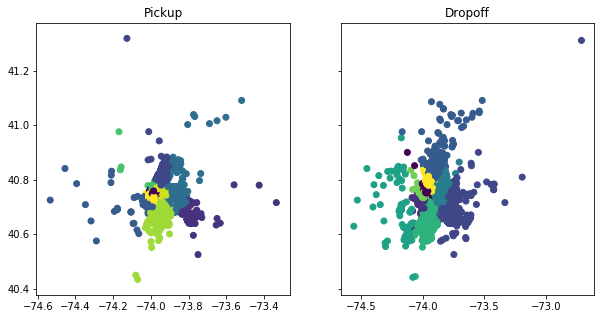

In [23]:
n = 100000 # Number of data points to plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_pickup[:n])
ax1.set_title('Pickup')
ax2.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_dropoff[:n])
ax2.set_title('Dropoff')
plt.show()

### calculate the distance between two point

In [24]:
from math import sin, cos, sqrt, atan2, radians
def calculate_distance(table):
    R = 3961

    lat1 = np.radians(table.pickup_latitude.values)
    lon1 = np.radians(table.pickup_longitude.values)
    lat2 = np.radians(table.dropoff_latitude.values)
    lon2 = np.radians(table.dropoff_longitude.values)

    dlon = lon2 - lon1
    dlat = lat2 - lat1 

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return np.round(R * c, 3)

In [25]:
df['distance'] = calculate_distance(df)

In [26]:
test['distance'] = calculate_distance(test)

### add more feature

In [27]:
ride_counts = df.groupby(['pick_month', 'pick_weekday','is_holiday',
           'kmeans_pickup']).size()
ride_counts = pd.DataFrame(ride_counts).reset_index()
ride_counts['ride_counts'] = ride_counts[0]
ride_counts = ride_counts.drop(0,1)

# Add `ride_counts` to dataframe
df = df.merge(ride_counts, on=['pick_month',
                          'pick_weekday',
                          'is_holiday',
                          'kmeans_pickup'], how='left')

In [28]:
ride_counts = test.groupby(['pick_month', 'pick_weekday','is_holiday',
           'kmeans_pickup']).size()
ride_counts = pd.DataFrame(ride_counts).reset_index()
ride_counts['ride_counts'] = ride_counts[0]
ride_counts = ride_counts.drop(0,1)

# Add `ride_counts` to dataframe
test = test.merge(ride_counts, on=['pick_month',
                          'pick_weekday',
                          'is_holiday',
                          'kmeans_pickup'], how='left')

In [29]:
test.shape

(625134, 25)

In [30]:
df.shape

(1458644, 26)

In [31]:
dummies = ['kmean_pickup_time','pick_month','pick_weekday','kmeans_pickup','kmeans_dropoff']
for feature in dummies:
    dummy_features = pd.get_dummies(df[feature], prefix=feature)
    for dummy in dummy_features:
        df[dummy] = dummy_features[dummy]
    df = df.drop([feature], 1)

In [32]:
df.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,pick_businessday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_11,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,0,455,0,1044,1.725,0,1,0,0,0,1,0.932,3241,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
dummies = ['kmean_pickup_time','pick_month','pick_weekday','kmeans_pickup','kmeans_dropoff']
for feature in dummies:
    dummy_features = pd.get_dummies(test[feature], prefix=feature)
    for dummy in dummy_features:
        test[dummy] = dummy_features[dummy]
    test = test.drop([feature], 1)

In [34]:
test.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,pick_businessday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.75668,0,0,1439,4.999306,0,1,0,0,0,1,1.708,3586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [35]:
print (df.shape)
print (test.shape)

(1458644, 88)
(625134, 85)


### manunly add missing columns

In [36]:
# test = test.drop(['kmeans_pickup_11'], axis=1)
test.insert(68, 'kmeans_pickup_11', 0)
# test = test.drop(['kmeans_dropoff_5'], axis=1)
test.insert(77, 'kmeans_dropoff_5', 0)

In [37]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,pick_businessday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_11,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,0,1439,4.999306,0,1,0,0,0,1,1.708,3586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,0,1439,4.999306,0,1,0,0,0,1,1.715,258,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,0,1439,4.999306,0,1,0,0,0,1,0.812,3586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,0,1439,4.999306,0,1,0,0,0,1,3.276,3005,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,0,1439,4.999306,0,1,0,0,0,1,0.597,3005,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### calculate directions

In [38]:
def calculate_direction(table):
    lat1 = np.radians(table.pickup_latitude.values)
    lon1 = np.radians(table.pickup_longitude.values)
    lat2 = np.radians(table.dropoff_latitude.values)
    lon2 = np.radians(table.dropoff_longitude.values)

    delta_rads = np.radians(lon2 - lon1)
    
    y = np.sin(delta_rads) * np.cos(lat1)
    
    x = (np.cos(lat1) * 
         np.sin(lat2) - 
         np.sin(lat1) * 
         np.cos(lat2) * 
         np.cos(delta_rads))
    return np.degrees(np.arctan2(y,x))

In [39]:
df['direction'] = calculate_direction(df)

In [40]:
test['direction'] = calculate_direction(test)

# add weather data into the table

## load and clean the data first 

In [157]:
weather = pd.read_csv('weather_data_nyc.csv')
weather.isnull().sum()

date                   0
maximum temperature    0
minimum temperature    0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
dtype: int64

In [158]:
weather.head(18)

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0
5,6-1-2016,41,25,33.0,0.00,0.0,0
6,7-1-2016,46,31,38.5,0.00,0.0,0
7,8-1-2016,46,31,38.5,0.00,0.0,0
8,9-1-2016,47,40,43.5,T,0.0,0
9,10-1-2016,59,40,49.5,1.80,0.0,0


### change T to 0

In [159]:
weather['precipitation'] = weather.precipitation.map(lambda x: 0.00 if x == 'T' else x)
weather['snow fall'] = weather['snow fall'].map(lambda x: 0.00 if x == 'T' else x)
weather['snow depth'] = weather['snow depth'].map(lambda x: 0.00 if x == 'T' else x)

### drop max/min

In [160]:
weather = weather.drop(['maximum temperature', 'minimum temperature'], axis=1)
weather.head()

,date,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,38.0,0.00,0.0,0
1,2-1-2016,36.0,0.00,0.0,0
2,3-1-2016,40.0,0.00,0.0,0
3,4-1-2016,25.0,0.00,0.0,0
4,5-1-2016,20.0,0.00,0.0,0


drop max and min since they didn't provide any time stamp, an average is sufficent

In [41]:
# print (weather.date.max())
# print (weather.date.min())

In [42]:
# date['dates'] = pd.to_datetime(weather.date, format='%m%d%y') 

# df['DOB1'] = df['DOB'].dt.strftime('%m/%d/%Y')

In [171]:
date.head()

0    1-1-2016
1    2-1-2016
2    3-1-2016
3    4-1-2016
4    5-1-2016
Name: date, dtype: object

## join two tables together

In [215]:
# ## create new columns for key
# df['date'] = test.pickup_datetime.dt.date
# df.head()

# Prepare the X_train, y_train, and X_test

In [43]:
#save the data into a file so we don't need to reload the data each time
df = df.drop(['pickup_datetime'], axis = 1)
test = test.drop(['pickup_datetime'], axis = 1)

df.to_csv("prepared.csv", encoding='utf-8', index=False)
test.to_csv("test_1.csv", encoding='utf-8', index=False)

In [3]:
df = pd.read_csv('prepared.csv')

test = pd.read_csv('test_1.csv')

In [5]:
df.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,pick_businessday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_11,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14,direction
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0,1044,1.725000,0,1,0,0,0,1,0.932,3241,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174.333393
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1,43,7.029861,0,1,0,0,0,0,1.123,7099,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-178.051723
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,0,695,2.482639,0,1,0,0,0,1,3.970,3280,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-179.630020
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,0,429,0,1172,3.813889,0,1,0,0,0,1,0.924,2221,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-179.872592
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,0,435,0,810,6.562500,0,1,0,0,0,0,0.739,3391,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,179.990814


In [6]:
test.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,pick_businessday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_11,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14,direction
0,id3004672,1,1,-73.988129,40.732029,-73.990173,40.756680,0,0,1439,4.999306,0,1,0,0,0,1,1.708,3586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.062854
1,id3505355,1,1,-73.964203,40.679993,-73.959808,40.655403,0,0,1439,4.999306,0,1,0,0,0,1,1.715,258,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,179.864469
2,id1217141,1,1,-73.997437,40.737583,-73.986160,40.729523,0,0,1439,4.999306,0,1,0,0,0,1,0.812,3586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,178.940121
3,id2150126,2,1,-73.956070,40.771900,-73.986427,40.730469,0,0,1439,4.999306,0,1,0,0,0,1,3.276,3005,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-179.445122
4,id1598245,1,1,-73.970215,40.761475,-73.961510,40.755890,0,0,1439,4.999306,0,1,0,0,0,1,0.597,3005,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,178.819522


In [4]:
# y_train = df['trip_duration']
# X_train = df.drop(['id', 'store_and_fwd_flag', 'trip_duration'], axis=1)
    
y = df['trip_duration']
X = df.drop(['id','passenger_count', 'store_and_fwd_flag', 'trip_duration'], axis=1)

#creat a table first for later submission
result_table = pd.DataFrame(columns =['id', 
                                      'trip_duration', 'trip_duration_2', 'trip_duration_3'])

result_table['id'] = test['id']


X_test = test.drop(['id', 'store_and_fwd_flag'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train.shape

In [ ]:
df.isnull().sum()

In [9]:
result_table.head()

,id,trip_duration,trip_duration_2,trip_duration_3
0,id3004672,NaN,NaN,NaN
1,id3505355,NaN,NaN,NaN
2,id1217141,NaN,NaN,NaN
3,id2150126,NaN,NaN,NaN
4,id1598245,NaN,NaN,NaN


# begin prediction

In [7]:
from sklearn.metrics import mean_squared_error
def calculate_error(y_test, y_pred):

    log_test = np.log(y_test+1)
    log_pred = np.log(y_pred+1)
    RMSE = np.sqrt(mean_squared_error(log_test, log_pred))
    
    return RMSE

# Random forest

### Grid search

In [8]:
%%time
from sklearn.ensemble import RandomForestRegressor as RFR

n_est = [5, 15, 20, 30 ,40]

RMSE_train_test = {}
regMLPs = {}
for n in n_est:
    model = RFR(n_estimators = 10, n_jobs = 3, max_depth = n, random_state = 2)
    model.fit(X_train, y_train)  
    y_pred_1 = model.predict(X_train)
    rmlse_1 = calculate_error(y_pred_1, y_train)
    print("the train error for modle with max_depth {} is: {}".format(n , rmlse_1))
    y_pred_2 = model.predict(X_test)
    rmlse_2 = calculate_error(y_pred_2, y_test)
    print("the test error for modle with max_depth {} is: {}".format(n ,rmlse_2))


the train error for modle with max_depth 5 is: 0.5992277338870665
the test error for modle with max_depth 5 is: 0.5984772606230899
the train error for modle with max_depth 15 is: 0.49455937945814027
the test error for modle with max_depth 15 is: 0.5476628878474649
the train error for modle with max_depth 20 is: 0.4274137253352441
the test error for modle with max_depth 20 is: 0.5483028792844816
the train error for modle with max_depth 30 is: 0.3334309158581955
the test error for modle with max_depth 30 is: 0.5599540422844758
the train error for modle with max_depth 40 is: 0.30545328330024113
the test error for modle with max_depth 40 is: 0.5615269274757699
CPU times: user 30min 49s, sys: 2.85 s, total: 30min 52s
Wall time: 10min 52s


In [9]:
n_est = [10, 30, 60, 100]

RMSE_train_test = {}
regMLPs = {}
for n in n_est:
    model_1 = RFR(n_estimators = 20, n_jobs = 3, max_depth = 30,  min_samples_split = n, random_state = 2)
    model_1.fit(X_train, y_train)  
    y_pred_1 = model_1.predict(X_train)
    rmlse_1 = calculate_error(y_pred_1, y_train)
    print("the train error for modle with min {} is: {}".format(n , rmlse_1))
    y_pred_2 = model_1.predict(X_test)
    rmlse_2 = calculate_error(y_pred_2, y_test)
    print("the test error for modle with min {} is: {}".format(n ,rmlse_2))

the train error for modle with min 10 is: 0.4097508100205833
the test error for modle with min 10 is: 0.5723278299116925
the train error for modle with min 30 is: 0.4554851221661863
the test error for modle with min 30 is: 0.5608036566226221
the train error for modle with min 60 is: 0.47948280234385027
the test error for modle with min 60 is: 0.5544134433925202
the train error for modle with min 100 is: 0.49341243753783887
the test error for modle with min 100 is: 0.5507089796432059


In [ ]:
n_est = [10, 20, 50, 100]

RMSE_train_test = {}
regMLPs = {}
for n in n_est:
    model_1 = RFR(n_estimators = 10, n_jobs = 3, random_state = 2)
    model_1.fit(X_train, y_train)  
    y_pred_1 = model_1.predict(X_train)
    rmlse_1 = calculate_error(y_pred_1, y_train)
    print("the train error for modle with n_est {} is: {}".format(n , rmlse_1))
    y_pred_2 = model_1.predict(X_test)
    rmlse_2 = calculate_error(y_pred_2, y_test)
    print("the test error for modle with n_est {} is: {}".format(n ,rmlse_2))

In [56]:
%%time
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [57]:
y_pred_1 = model.predict(X_train)

In [58]:
rmlse_1 = calculate_error(y_pred_1, y_train)
print("the error for modle with date is: {}".format(rmlse_1))

the error for modle with date is: 0.3049036650485407


In [59]:
y_pred_2 = model.predict(X_test)

In [60]:
rmlse_2 = calculate_error(y_pred_2, y_test)
print("the error for modle with date is: {}".format(rmlse_2))

the error for modle with date is: 0.5653894793371647


# ------------------------------------------------------------------------------------------

In [14]:
from sklearn.ensemble import RandomForestRegressor as RFR
regr = RFR(n_estimators = 10,
          max_depth = 100,
          min_samples_split = 500,
          verbose = 2,
          random_state = 2)

regr.fit(X_train, y_train)

building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.4s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.1min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=500,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=2, verbose=2, warm_start=False)

In [15]:
y_pred = regr.predict(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


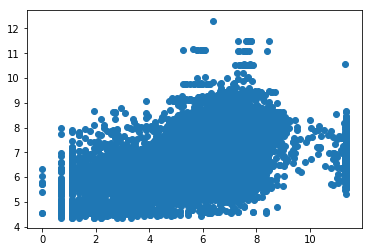

In [16]:
plt.scatter(np.log(y_test), np.log(y_pred))

plt.show()

In [17]:
rmlse = calculate_error(y_pred, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 0.5542805449882868


In [69]:
regr.feature_importances_

array([  1.55798068e-03,   1.02724051e-01,   1.17081973e-01,
         4.87540532e-02,   6.28403770e-02,   2.54541257e-06,
         7.36995320e-02,   8.17414490e-02,   3.06448219e-04,
         3.88038343e-05,   2.45193200e-04,   1.58531269e-03,
         8.74573580e-04,   1.24898112e-03,   9.78865111e-02,
         6.44403610e-02,   2.21382291e-03,   6.99822502e-05,
         5.77246657e-04,   4.49741140e-04,   2.55734640e-04,
         3.26787978e-04,   8.76455856e-04,   9.02391659e-04,
         2.52904816e-04,   5.47867654e-02,   1.27075655e-03,
         1.75652711e-05,   6.14084291e-04,   2.28191912e-04,
         7.12609425e-04,   4.94176453e-03,   1.35490893e-03,
         5.44020184e-04,   8.19170109e-04,   9.44257798e-04,
         8.57026448e-04,   5.85587639e-04,   3.47690680e-04,
         4.89567807e-04,   1.10735802e-03,   5.77300962e-04,
         5.77924568e-04,   4.61391553e-04,   7.43609281e-04,
         6.68283428e-04,   7.64397345e-05,   8.47736545e-04,
         4.86985867e-04,

In [70]:
import operator

dict_feature_imp = dict(zip(list(X_train.columns), regr.feature_importances_))
sorted_feature = sorted(dict_feature_imp.items(), key = operator.itemgetter(1), reverse= True)
sorted_feature

[('direction', 0.21975446470587762),
 ('pickup_latitude', 0.11708197313872488),
 ('pickup_longitude', 0.10272405057058145),
 ('distance', 0.097886511120969286),
 ('week_delta', 0.081741449024940419),
 ('pick_minuteofday', 0.073699531979210614),
 ('ride_counts', 0.064440360970340935),
 ('dropoff_latitude', 0.062840377013731324),
 ('kmean_pickup_time_9', 0.054786765373648502),
 ('dropoff_longitude', 0.048754053186779694),
 ('kmeans_pickup_13', 0.04005395477792055),
 ('kmean_pickup_time_15', 0.0049417645316187104),
 ('kmean_pickup_time_0', 0.0022138229069682195),
 ('many_passengers', 0.0015853126856636395),
 ('vendor_id', 0.0015579806770264564),
 ('kmean_pickup_time_16', 0.0013549089270025283),
 ('kmean_pickup_time_10', 0.0012707565522612995),
 ('pick_businessday', 0.0012489811156228281),
 ('pick_month_1', 0.0011073580184487823),
 ('pick_weekday_5', 0.0010132830414869478),
 ('kmean_pickup_time_19', 0.00094425779842077144),
 ('kmean_pickup_time_7', 0.00090239165869752567),
 ('kmean_pickup_

In [102]:
rmlse = calculate_error(y_pred, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 0.5547016921176614


In [71]:
y_test.values

array([1040,  827,  614, ...,  454, 1947, 1217])

In [72]:
y_pred

array([  773.7257376 ,  1708.48677982,   433.51723264, ...,   613.14122567,
        2086.67484098,  1155.07428747])

# MLP Regressor

## thought about MLP

base on the model I ran, the error for modle with "relu" is the lowest. Hence, I decided to run a Gridsearch function for tunning

In [64]:
from sklearn.neural_network import MLPRegressor
param_hidden_layers = [(1, 2),(7,2), (8,2), (10, 4),(13,6)]

RMSE_train_test = {}
regMLPs = {}
for param_hidden in param_hidden_layers:
    regMLP_t = MLPRegressor(
                hidden_layer_sizes= param_hidden, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
                random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    regMLP_t.fit(X_train, y_train)
    y_pred = regMLP_t.predict(X_test)
    rmlse = calculate_error(y_pred, y_test)
    print("the error for {} hidden_laye is: {}".format(param_hidden, rmlse))

the error for (1, 2) hidden_laye is: 0.7605391236409907
the error for (7, 2) hidden_laye is: 0.8895771069193265
the error for (8, 2) hidden_laye is: 0.6795053052006176
the error for (10, 4) hidden_laye is: 0.6499066303562581


/home/zhangtong/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in log



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [79]:
param_hidden_layers = [(11,2), (13,2), (10, 2)]

RMSE_train_test = {}
regMLPs = {}
for param_hidden in param_hidden_layers:
    regMLP_t = MLPRegressor(
                hidden_layer_sizes= param_hidden, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
                random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    regMLP_t.fit(X_train, y_train)
    y_pred = regMLP_t.predict(X_test)
    rmlse = calculate_error(y_pred, y_test)
    print("the error for {} hidden_laye is: {}".format(param_hidden, rmlse))

the error for (11, 2) hidden_laye is: 0.6345189875998685
the error for (13, 2) hidden_laye is: 0.8629391029958269
the error for (10, 2) hidden_laye is: 0.6681810633947554


base on the result above, I choose to test different learning rate on (10, 2), (13, 2) using K-fold

In [12]:
from sklearn.neural_network import MLPRegressor

param_hidden_layers = (10,2)


lrate = [0.005, 0.01, 0.001]

for lrate_ in lrate:
    regMLP = MLPRegressor(
                hidden_layer_sizes= param_hidden_layers, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                learning_rate='adaptive', learning_rate_init=lrate_, power_t=0.5, max_iter=1000, shuffle=True,
                random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    regMLP.fit(X_train, y_train)
    y_pred = regMLP.predict(X_test)
    rmlse = calculate_error(y_pred, y_test)
    print("the error for learning rate {} hidden_laye is: {}".format(lrate_, rmlse))
    


the error for learning rate 0.005 hidden_laye is: 0.7416836681806266
the error for learning rate 0.01 hidden_laye is: 0.7602652856079924


/home/zhangtong/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in log



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [78]:
param_hidden_layers = (10,3)
from sklearn.neural_network import MLPRegressor
lrate = [0.005, 0.001, 0.01]

for lrate_ in lrate:
    regMLP = MLPRegressor(
                hidden_layer_sizes= param_hidden_layers, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                learning_rate='adaptive', learning_rate_init=lrate_, power_t=0.5, max_iter=1000, shuffle=True,
                random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    regMLP.fit(X_train, y_train)
    y_pred = regMLP.predict(X_test)
    rmlse = calculate_error(y_pred, y_test)
    print("the error for learning rate {} hidden_laye is: {}".format(lrate_, rmlse))

the error for learning rate 0.005 hidden_laye is: 0.7565117167931386
the error for learning rate 0.001 hidden_laye is: 0.6432535210313949
the error for learning rate 0.01 hidden_laye is: 0.7069885811431931


In [79]:
from sklearn.neural_network import MLPRegressor

regMLP_t = MLPRegressor(
                hidden_layer_sizes= (10, 2), activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                learning_rate='adaptive', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
                random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

regMLP_t.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 2), learning_rate='constant',
       learning_rate_init=0.01, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=9, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [80]:
MLP_pred = regMLP_t.predict(X_test)

In [84]:
MLP_pred

array([ 1032.14428911,   733.70937896,   729.81916879, ...,  1006.12027124,
        2617.83973116,  1235.27633292])

In [85]:
y_test.values

array([1040,  827,  614, ...,  454, 1947, 1217])

In [86]:
rmlse = calculate_error(MLP_pred, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 0.6832835175060691


In [87]:
rmlse = calculate_error((MLP_pred+y_pred)/2, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 0.6059043543151305


In [24]:
%%time
from xgboost.sklearn import XGBRegressor
clf_xgb = XGBRegressor(learning_rate=0.001, n_estimators=10, max_depth=5, objective='reg:linear')
clf_xgb.fit(X_train, y_train)


CPU times: user 1min 6s, sys: 924 ms, total: 1min 7s
Wall time: 18.9 s


In [25]:
%%time
XGB_pred = clf_xgb.predict(X_test)

CPU times: user 960 ms, sys: 236 ms, total: 1.2 s
Wall time: 931 ms


In [26]:
XGB_pred = np.abs(XGB_pred)

In [27]:
rmlse = calculate_error(XGB_pred, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 4.21005617322225


In [22]:
%%time
rmlse = calculate_error((XGB_pred+y_pred)/2, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 0.6462450660164726
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 37.6 ms


In [28]:
n_est = [10, 20, 30, 100]

for n in n_est:
    clf_xgb = XGBRegressor(n_estimators=n)
    clf_xgb.fit(X_train, y_train)
    XGB_pred = clf_xgb.predict(X_test)
    XGB_pred = np.abs(XGB_pred)
    rmlse = calculate_error(XGB_pred, y_test)
    print("the error for modle with n_est {} is: {}".format(n, rmlse))

the error for modle with n_est 10 is: 0.5671462150809942
the error for modle with n_est 20 is: 0.560276162186612
the error for modle with n_est 30 is: 0.5813114782688616
the error for modle with n_est 100 is: 0.5718042414771639


In [29]:
n_est = [3, 5, 10, 20]

for n in n_est:
    clf_xgb = XGBRegressor(n_estimators=50, max_depth = n)
    clf_xgb.fit(X_train, y_train)
    XGB_pred = clf_xgb.predict(X_test)
    XGB_pred = np.abs(XGB_pred)
    rmlse = calculate_error(XGB_pred, y_test)
    print("the error for modle with depth {} is: {}".format(n, rmlse))

the error for modle with depth 3 is: 0.5844512728948079
the error for modle with depth 5 is: 0.5660891685687569
the error for modle with depth 10 is: 0.5402939570914693
the error for modle with depth 20 is: 0.5380481853664125


In [30]:
n_est = [0.5, 0.1, 0.01, 0.001]

for n in n_est:
    clf_xgb = XGBRegressor(n_estimators=50, max_depth = 5, learning_rate = n,  nthread=3)
    clf_xgb.fit(X_train, y_train)
    XGB_pred = clf_xgb.predict(X_test)
    XGB_pred = np.abs(XGB_pred)
    rmlse = calculate_error(XGB_pred, y_test)
    print("the error for modle with depth {} is: {}".format(n, rmlse))

the error for modle with depth 0.5 is: 0.5719892098432573
the error for modle with depth 0.1 is: 0.5660891685687569
the error for modle with depth 0.01 is: 0.8576168935418749
the error for modle with depth 0.001 is: 2.778757194514751


### test 2

In [122]:
%%time
clf_xgb = XGBRegressor(learning_rate=0.01, n_estimators=100, max_depth=6, objective='reg:linear',  min_child_weight=20)
clf_xgb.fit(X_train, y_train)


CPU times: user 12min 35s, sys: 1.78 s, total: 12min 36s
Wall time: 3min 15s


In [126]:
%%time
XGB_pred_1 = clf_xgb.predict(X_test)

CPU times: user 4.54 s, sys: 512 ms, total: 5.06 s
Wall time: 3.2 s


In [127]:
XGB_pred_1 = np.abs(XGB_pred_1)

In [128]:
%%time
rmlse = calculate_error(XGB_pred_1, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 0.5665891482554231
CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 65.8 ms


In [129]:
%%time
rmlse = calculate_error((XGB_pred_1+y_pred)/2, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 0.5148748780803357
CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 121 ms
